In [1]:
# Importing basic libs
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# User verification for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}.')

Using cuda:0.


In [3]:
# Model implementation
class LeNet_5(Module):
  def __init__(self):
    """
      LeNet-5 (1998)
      Input : 1x32x32
      Output : 10x1
    """
    super(LeNet_5, self).__init__()
    self.C1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5), stride = 1) # 6 x 28 x 28 output
    self.S2 = nn.AvgPool2d(kernel_size = (2,2), stride = 2) # 6 x 14 x 14 output
    self.C3 = nn.Conv2d(6, 16, 5) # 16 x 10 x 10 output
    self.S4 = nn.AvgPool2d(kernel_size = (2,2), stride = 2) # 16 x 5 x 5 output
    self.C5 = nn.Conv2d(16, 120, 5) # 1 x 1 x 120 output
    self.F6 = nn.Linear(120, 84) # 84 x 1 output
    self.OUT = nn.Linear(84, 10) # Changing RBF to linear layer + logsoftmax
    self.TO_PROBS = nn.LogSoftmax(dim = 1)

    self.A = 1.7159
    self.activation = nn.Tanh() # modified tanh activation


  def forward(self, X):
    y = self.C1(X)
    y = self.S2(y)
    y = self.A * self.activation(y)
    y = self.C3(y)
    y = self.S4(y)
    y = self.A * self.activation(y)
    y = self.C5(y)
    y = torch.flatten(y, 1)
    y = self.A * self.activation(y)
    y = self.F6(y)
    y = self.A * self.activation(y)
    logits = self.OUT(y)
    probs = self.TO_PROBS(logits)
    return y

In [4]:
# Creating data formatter and loaders
LeNet_5_format = transforms.Compose([transforms.Resize((32, 32)),
                                     transforms.ToTensor()])

training_set = datasets.MNIST(root='mnist_data', train = True, transform = LeNet_5_format, download=True)
validation_set = datasets.MNIST(root='mnist_data', train = False, transform = LeNet_5_format)

training_loader = DataLoader(training_set, batch_size = 32, shuffle = True)
validation_loader = DataLoader(validation_set, batch_size = 5, shuffle = False)

Checking training loader : 
Batch shape : torch.Size([32, 1, 32, 32])
Checking training loader : 
Batch shape : torch.Size([32, 1, 32, 32])
Checking training loader : 
Batch shape : torch.Size([32, 1, 32, 32])
Checking training loader : 
Batch shape : torch.Size([32, 1, 32, 32])
Checking validation loader : 
Batch shape : torch.Size([5, 1, 32, 32]) batch labels : tensor([7, 2, 1, 0, 4])
Checking validation loader : 
Batch shape : torch.Size([5, 1, 32, 32]) batch labels : tensor([1, 4, 9, 5, 9])
Checking validation loader : 
Batch shape : torch.Size([5, 1, 32, 32]) batch labels : tensor([0, 6, 9, 0, 1])
Checking validation loader : 
Batch shape : torch.Size([5, 1, 32, 32]) batch labels : tensor([5, 9, 7, 3, 4])


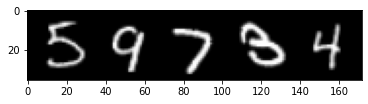

In [5]:
# Some sanity checks
def viz(image):
  image = image.numpy().transpose((1, 2, 0))
  plt.imshow(image)

for i, data in enumerate(training_loader):
  print("Checking training loader : ")
  batch, labels = data
  print(f'Batch shape : {batch.shape}')
  if i == 3:
    break
print("==================")
for i, data in enumerate(validation_loader):
  print("Checking validation loader : ")
  batch, labels = data
  print(f'Batch shape : {batch.shape} batch labels : {labels}')
  batch_viz = torchvision.utils.make_grid(batch)
  viz(batch_viz)
  if i == 3:
    break

In [6]:
lenet = LeNet_5().to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optim = torch.optim.SGD(lenet.parameters(),lr = lr)

In [7]:
# Defining single epoch training pass
def trainer(model, dataloader, criterion, optimizer):
  model.train()
  running_loss = 0.0

  for X, y_T in dataloader:
      optimizer.zero_grad()

      X = X.to(device)
      y_T = y_T.to(device)

      probs = model(X)   
      loss = criterion(probs, y_T)
      running_loss += loss.item() * X.size(0)

      loss.backward()
      optimizer.step()
  epoch_loss = running_loss / len(dataloader.dataset)
  return model, optimizer, epoch_loss

In [8]:
# Define single epoch testing pass
def tester(model, dataloader, criterion, optimizer):
  model.eval()
  running_loss = 0.0

  for X, y_T in dataloader:
      X = X.to(device)
      y_T = y_T.to(device)

      probs = model(X)
      loss = criterion(probs, y_T)
      running_loss += loss.item() * X.size(0)
  epoch_loss = running_loss / len(dataloader.dataset)
  return model, epoch_loss

In [9]:
# Custom function to compute accuracy
def compute_accuracy(model, dataloader):
    correct_preds = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_T in dataloader:

            X = X.to(device)
            y_T = y_T.to(device)

            probs = model(X)
            _, predictions = torch.max(probs, 1)

            n += y_T.size(0)
            correct_preds += (predictions == y_T).sum()

    return correct_preds.float() / n

In [10]:
# Defining model trainer
def training(model, training_loader, validation_loader, criterion, optimizer, epochs):
  train_losses = []
  train_acc =[]
  valid_losses = []
  valid_acc = []

  for epoch in range(epochs):
    print(f'\nEpoch {epoch} : ')
    print("===========")
    
    model, optimizer, training_loss = trainer(model, training_loader, criterion, optimizer)
    training_acc = compute_accuracy(model, training_loader)
    train_losses.append(training_loss)
    train_acc.append(training_acc)

    with torch.no_grad():
      model, valid_loss = tester(model, validation_loader, criterion, optimizer)
      validation_acc = compute_accuracy(model, validation_loader)
      valid_losses.append(valid_loss)
      valid_acc.append(validation_acc)

    print(f'Training loss : {training_loss}')
    print(f'Training acc : {training_acc}')
    print(f'Validation loss : {valid_loss}')
    print(f'Validation acc : {validation_acc}')

  train_losses = np.array(train_losses) 
  valid_losses = np.array(valid_losses)
  train_acc = np.array(train_acc)
  valid_acc = np.array(valid_acc)

  fig, ax = plt.subplots(figsize = (10, 5))
  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(train_acc, color='green', label='Training accuracy') 
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.plot(valid_acc, color='black', label='Validation accuracy')
  
  ax.set(title="Loss evolution", 
            xlabel='Epoch',
            ylabel='Loss/Accuracy') 
  ax.legend()
  fig.show()
    


Epoch 0 : 
Training loss : 2.6665022141774495
Training acc : 0.09871666878461838
Validation loss : 2.440473958849907
Validation acc : 0.0982000008225441

Epoch 1 : 
Training loss : 2.1600451760609944
Training acc : 0.8183833360671997
Validation loss : 1.9071612289547921
Validation acc : 0.819599986076355

Epoch 2 : 
Training loss : 1.8149600207646688
Training acc : 0.8411666750907898
Validation loss : 1.7356506712436677
Validation acc : 0.8438999652862549

Epoch 3 : 
Training loss : 1.7033717555363972
Training acc : 0.8687166571617126
Validation loss : 1.6604275251626968
Validation acc : 0.8740999698638916

Epoch 4 : 
Training loss : 1.6459020438512166
Training acc : 0.8801833391189575
Validation loss : 1.6159123264551163
Validation acc : 0.8868999481201172

Epoch 5 : 
Training loss : 1.6089685336430868
Training acc : 0.8886666893959045
Validation loss : 1.585907732605934
Validation acc : 0.8944000005722046

Epoch 6 : 
Training loss : 1.5817925891240439
Training acc : 0.89766669273376

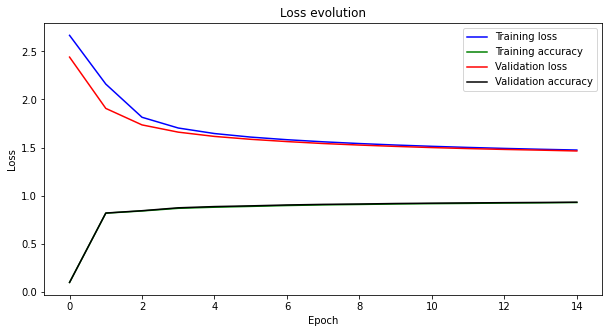

In [11]:
training(lenet, training_loader, validation_loader, criterion, optim, 15)